In [1]:
from diffUV import dyned_eul, dyn_body, kin, dyned_quat
from diffUV.utils.symbols import *
from diffUV.utils.quaternion_ops import euler2q, q2euler
from casadi import *
from blue_rov import Params as ps
import numpy as np
import os
from scipy.spatial.transform import Rotation as R

In [2]:
## unit quaternion from euler angles

# euler2qf = Function('euler2q', [eul], [euler2q(eul)])
# phi_f = 10*(pi/180)
# psi_f = 30*(pi/180)
# theta_f = -20*(pi/180)
# euler2qf([phi_f, theta_f, psi_f])

In [3]:
## euler angles from a unit quaternion

q2eulerf = Function('q2euler', [uq], [q2euler(uq)])
# q_f = np.array([0.9437, 0.1277, -0.1449, 0.2685])
# q2eulerf(q_f)

In [4]:
r_g = vertcat(x_g, y_g, z_g) # center of gravity wrt body origin
r_b = vertcat(x_b, y_b, z_b) # center of buoyancy wrt body origin 
I_o = vertcat(I_x, I_y, I_z,I_xz) # rigid body inertia wrt body origin

decoupled_added_m = vertcat(X_du, Y_dv, Z_dw, K_dp, M_dq, N_dr) # added mass in diagonals
coupled_added_m =  vertcat(X_dq, Y_dp, N_dp, M_du, K_dv) # effective added mass in non diagonals

linear_dc = vertcat(X_u, Y_v, Z_w, K_p,  M_q, N_r) # linear damping coefficients
quadratic_dc = vertcat(X_uu, Y_vv, Z_ww, K_pp, M_qq, N_rr) # quadratic damping coefficients

n0 = vertcat(n, dn) # state variables wrt ned
x_nb # velocity state variables wrt body

SX([u, v, w, p, q, r])

<h1>Kinematics ned Transformation Matrix</h1>

In [5]:
Kinematics = kin()
Jk = Kinematics.J
J_inv = Kinematics.J_INV
print(J_inv)
J_inv_func = Function('J_inv', [eul], [J_inv]) # for numerical & symbolic use

@1=0, 
[[(cos(psi)*cos(thet)), (sin(psi)*cos(thet)), (-sin(thet)), @1, @1, @1], 
 [(((cos(psi)*sin(thet))*sin(phi))-(sin(psi)*cos(phi))), ((cos(psi)*cos(phi))+((sin(phi)*sin(thet))*sin(psi))), (cos(thet)*sin(phi)), @1, @1, @1], 
 [((sin(psi)*sin(phi))+((cos(psi)*cos(phi))*sin(thet))), (((sin(thet)*sin(psi))*cos(phi))-(cos(psi)*sin(phi))), (cos(thet)*cos(phi)), @1, @1, @1], 
 [@1, @1, @1, 1, 00, (-sin(thet))], 
 [@1, @1, @1, 00, cos(phi), (cos(thet)*sin(phi))], 
 [@1, @1, @1, 00, (-sin(phi)), (cos(thet)*cos(phi))]]


In [6]:
# example usage of J mat
jinv = np.array(J_inv_func([0.13,0.17,0.1]))
jinv

array([[ 0.98066095,  0.09839429, -0.16918235,  0.        ,  0.        ,
         0.        ],
       [-0.07716877,  0.98879774,  0.12776544,  0.        ,  0.        ,
         0.        ],
       [ 0.17985851, -0.11223898,  0.9772683 ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        -0.16918235],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.99156189,
         0.12776544],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.12963414,
         0.9772683 ]])

In [7]:
# reverse scipy convention
def q_reverse(q):
    x, y, z, w = q
    return np.array([w, x, y, z])

def eul_reverse(eul):
    phi, thet, psi = eul
    return np.array([psi, thet, phi])

In [8]:
x_nb, uq

(SX([u, v, w, p, q, r]), SX([eta, eps1, eps2, eps3]))

In [9]:
# state transformations
J_ = Kinematics.J
Jq_ = Kinematics.Jq

J_func = Function('J_', [eul], [J_[3:,3:]])
Jq_func = Function('Jq_', [uq], [Jq_[3:,3:]])

x_nb_v = np.array([0, 0.2, 0.0, 0.5, 0, 0.1])
r = R.from_euler("ZYX", (10, 10, 20), degrees=True)
eul_v = r.as_euler("ZYX")
uq_v = r.as_quat()

# print(uq_v)

 #, r.as_matrix()

To = J_func(eul_reverse(eul_v))
Tq = Jq_func(q_reverse(uq_v))


# state discrete time propagation in euler
h = 0.05
wk_next = eul_reverse(eul_v) + h*To@x_nb_v[3:]

# state discrete time propagation and normalization in unit quaternion
qk_next = q_reverse(uq_v)+ h*Tq@x_nb_v[3:]
norm_qk_next = qk_next/sqrt(qk_next.T@qk_next)


# response
print(wk_next)
print(norm_qk_next)


#checking for property 8.17 --> eye(3)
4*(Tq.T@Tq) 

[0.374894, 0.172823, 0.179304]
[0.97633, 0.177319, 0.101042, 0.0716117]


DM(
[[1, 3.91182e-19, 2.28221e-18], 
 [3.91182e-19, 1, 1.2201e-17], 
 [2.28221e-18, 1.2201e-17, 1]])

In [10]:
# compare euler and quaternion results
rr = R.from_euler("ZYX", (0.179304, 0.172823, 0.374894), degrees=False)
q_reverse(rr.as_quat()) , norm_qk_next

# as expected both quaternion and euler produce same response

(array([0.97632635, 0.1773187 , 0.10107384, 0.07161717]),
 DM([0.97633, 0.177319, 0.101042, 0.0716117]))

<h1>Vehicle Dynamics</h1>

In [11]:
# body representaion
uv_body = dyn_body()

# ned representaion
uv_ned = dyned_eul()

# quaternion representation
uv_quat = dyned_quat()

<h1>System Inertia Matrix example</h1>

In [12]:
inertia_mat = uv_body.body_inertia_matrix()
M_func = Function('M_b', [m, I_o, z_g, decoupled_added_m, coupled_added_m], [inertia_mat]) # for numerical & symbolic use

In [13]:
# example usage of inertia mat
M_mat = np.array(M_func(ps.m, ps.Io, ps.rg[2], ps.added_m, ps.coupl_added_m))
M_mat

array([[17.  ,  0.  ,  0.  ,  0.  ,  0.23,  0.  ],
       [ 0.  , 24.2 ,  0.  , -0.23,  0.  ,  0.  ],
       [ 0.  ,  0.  , 26.07,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.23,  0.  ,  0.28,  0.  ,  0.  ],
       [ 0.23,  0.  ,  0.  ,  0.  ,  0.28,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.  ,  0.  ,  0.28]])

In [14]:
inertia_ned_mat = uv_ned.ned_euler_inertia_matrix()
Onb = vertcat(thet, phi, psi)
M_ned_func = Function('M_ned', [m, I_o, z_g, Onb, decoupled_added_m, coupled_added_m], [inertia_ned_mat]) # for numerical & symbolic use

In [15]:
# example usage of inertia mat in ned
Onb_v = np.array([0.13,0.17,0.1])
np.array(M_ned_func(ps.m, ps.Io, ps.rg[2], Onb_v,  ps.added_m, ps.coupl_added_m))

array([[ 1.72303360e+01, -7.45090577e-01,  1.18405662e+00,
         1.76115723e-02,  2.23648786e-01,  3.57838329e-02],
       [-7.45090577e-01,  2.41747103e+01, -1.91929773e-01,
        -2.26055609e-01,  2.24397276e-02,  3.31239544e-02],
       [ 1.18405662e+00, -1.91929773e-01,  2.58649536e+01,
        -3.85835972e-02, -2.93860503e-02,  0.00000000e+00],
       [ 1.76115723e-02, -2.26055609e-01, -3.85835972e-02,
         2.80000000e-01,  0.00000000e+00, -3.62975599e-02],
       [ 2.23648786e-01,  2.24397276e-02, -2.93860503e-02,
         0.00000000e+00,  2.80000000e-01,  0.00000000e+00],
       [ 3.57838329e-02,  3.31239544e-02,  0.00000000e+00,
        -3.62975599e-02,  0.00000000e+00,  2.80000000e-01]])

In [16]:
# checks --> above results (inertia mat in ned using body inertia and J tansform)
jinv.T@M_mat@jinv 

array([[ 1.73362823e+01, -7.32488329e-01,  1.52324571e+00,
         1.77488172e-02,  2.23648786e-01,  2.58149654e-02],
       [-7.32488329e-01,  2.41538511e+01, -8.52604453e-02,
        -2.27423481e-01,  2.24397276e-02,  4.13674584e-02],
       [ 1.52324571e+00, -8.52604453e-02,  2.57798665e+01,
        -2.93860503e-02, -3.85835972e-02, -7.71263355e-19],
       [ 1.77488172e-02, -2.27423481e-01, -2.93860503e-02,
         2.80000000e-01,  0.00000000e+00, -4.73710577e-02],
       [ 2.23648786e-01,  2.24397276e-02, -3.85835972e-02,
         0.00000000e+00,  2.80000000e-01, -2.51507399e-18],
       [ 2.58149654e-02,  4.13674584e-02,  7.71263355e-19,
        -4.73710577e-02, -2.45961687e-18,  2.80000000e-01]])

<h1>Forward dynamics simulation example</h1>

In [17]:
Jq_dot = Kinematics.Jq_dot

v_ddot = uv_body.body_forward_dynamics()

xd = Jq_@x_nb
ode_xdd = v_ddot

ode = vertcat(xd, ode_xdd) #the complete ODE vector
f_ode = Function('Odefunc', [m, W, B, r_g, r_b, I_o,
                           decoupled_added_m, coupled_added_m,
                           linear_dc, quadratic_dc,
                           x_nb, n, uq, tau_b], [ode])

In [18]:
n_arg = vertcat(p_n, q2euler(uq))
f_ode_simplify = f_ode(ps.m, ps.W, ps.B, ps.rg, ps.rb, ps.Io, ps.added_m,
                       ps.coupl_added_m, ps.linear_dc, ps.quadratic_dc, x_nb,  n_arg, uq,  tau_b)

f_ode_simplify_func = Function('f_ode_simplify', [x_nb , uq, tau_b], [f_ode_simplify]) ## RETURNS vertcat(p_n ,uq , x_nb)
f_ode_simplify_func

Function(f_ode_simplify:(i0[6],i1[4],i2[6])->(o0[13]) SXFunction)

In [19]:
u0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
q0 = np.array([1, 0, 0 ,0])
v_b0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
p0 = np.array([0.0, 0.0, 0.0])
#accelerations tests
np.array(f_ode_simplify_func(v_b0, q0, u0))

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.07614116],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [20]:
T = 10 # time horizon
N = 1600 # number of control intervals

# integrator to discretize the system
dae = {'x':vertcat(p_n, uq, x_nb), 'p':tau_b, 'ode': f_ode_simplify_func(x_nb ,uq, tau_b)}
intg = integrator('intg', 'rk', dae, {'tf':T/N, 'number_of_finite_elements':100, 'simplify':True})

CasADi - 2024-06-17 16:29:55 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:521]


In [21]:
xS0 = vertcat(p_n, uq, x_nb)
# print(xS0)
res = intg(x0=xS0,p=tau_b) #evaluate with symbols
x_next = res['xf']
x_next[3:7] = x_next[3:7]/sqrt(x_next[3:7].T@x_next[3:7])  #quaternions requires normalization

x_next[9] = if_else(x_next[2] < 0, 0,  x_next[9]) # if vehicle on surface, no more up motion
x_next[2] = if_else(x_next[2] < 0, 0,  x_next[2]) # if vehicle on surface, keep on surface and not go up

In [22]:
# Simplify API to (x,u)->(x_next)
F = Function('F',[xS0,tau_b],[x_next])

In [23]:
q0 = np.array([1, 0, 0 ,0])
x0 = vertcat(p0, q0, v_b0)
F(x0,u0)

DM([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
sim = F.mapaccum(N)
res = sim(x0, u0)

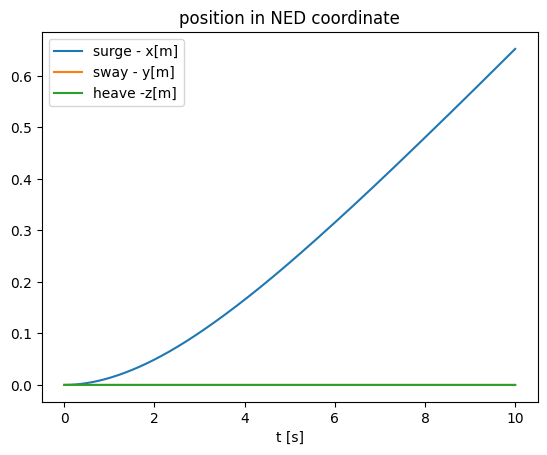

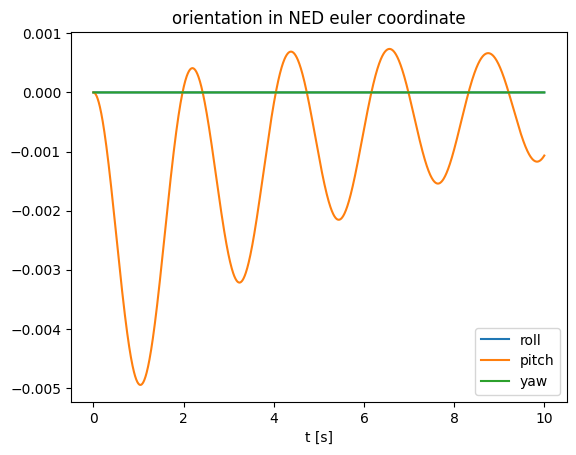

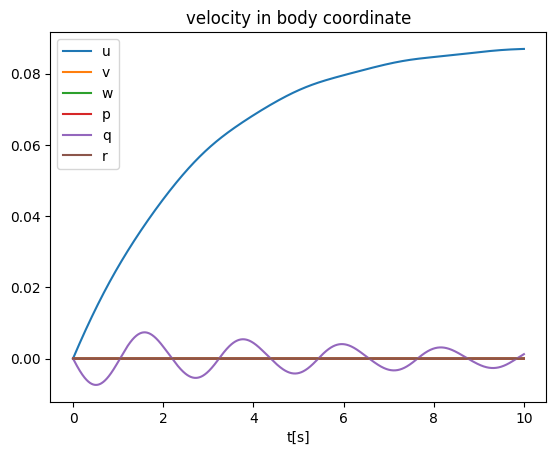

In [25]:
# SIMULATING vehicle on water surface
import matplotlib.pyplot as plt
u0 = np.array([0.5, 0.0, 0.0, 0.0, 0.0, 0.0])
res = sim(x0, u0)
res.T
t = np.linspace(0, T, N+1)

import math
 
def euler_from_quaternion(q):
        w, x, y, z = q
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return np.array([roll_x, pitch_y, yaw_z]) # in radians

# Create a figure and plot the data
plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((13,1)), res.toarray()), axis=1)[0:3,:].T)
plt.legend(['surge - x[m]', 'sway - y[m]', 'heave -z[m]'])
plt.title("position in NED coordinate")
plt.xlabel('t [s]')

plt.figure()
vfunc = np.vectorize(euler_from_quaternion, signature='(n)->(k)')
rpy_array = vfunc(np.concatenate((np.array(x0).reshape((13,1)), res.toarray()), axis=1)[3:7,:].T)
plt.plot(t, rpy_array)
plt.legend(['roll', 'pitch', 'yaw'])
plt.title("orientation in NED euler coordinate")
plt.xlabel('t [s]')

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((13,1)), res.toarray()), axis=1)[7::,:].T)
plt.legend(['u', 'v', 'w', 'p', 'q', 'r'])
plt.xlabel('t[s]')
plt.title("velocity in body coordinate")
plt.show()



# Code generation

In [93]:
# c , cpp or matlab code generation for forward dynamics
F.generate("F_next.c")
os.system(f"gcc -fPIC -shared F_next.c -o libF_next.so")

0